In [203]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

@nb.njit 
def movingaverage(wvf:np.ndarray, wvf_padded:np.ndarray, N:int):
    ret = np.zeros(shape=(len(wvf),len(wvf[0])))
    window = np.ones((N,))/N
    for i, w in enumerate(wvf_padded):
        b = np.convolve(w, window,mode="valid")
        ret[i] = b
    return ret

In [206]:
class DataClass:
    
    def __init__(self, f, smooth=7):
        self.time = 0
        self.wvf = 0
        self.charge = 0
        self.time, self.raw = self.extract_info(f)

        self.window = smooth
        self.compute_baseline()
        self.compute_charge()


    def extract_info(self, filename):
        npts = np.fromfile(filename,dtype=np.uint32,count=1)[0]
        dt = np.dtype([
            ('npts', np.uint32),
            ('timestamps', np.uint64),
            ('wvfs', (np.uint16,npts))])
        data = np.fromfile(filename, dtype=dt)
        print(f"Loaded data... {filename}")
        

        return data['timestamps'], -1*data['wvfs']

    def compute_baseline(self, wvf=None):
        print("Computing baseline...")
        if wvf is None:
            wvf = self.raw
        wvfpad = self.make_pads(wvf, self.window)
        wvffiltered = movingaverage(wvf, wvfpad, self.window)
        print("\tMoving average done")

        modes = st.mode(wvffiltered, axis=-1, keepdims=True)[0]
        print("\t\tModes computed")
        valids = np.abs(wvffiltered-modes)
        valids = valids<10
        baseregion = np.where(valids, wvffiltered, np.nan)
        print("\t\tFinishing ... ")
        self.baselines = np.nanmean(baseregion, axis=-1, keepdims=True)
        self.wvf =  wvffiltered-self.baselines
        self.raw =  self.raw-self.baselines

    def compute_charge(self):
        print("\t\t\tComputing charge...")
        self.charge = np.sum(self.raw[:,startpoint[run]:startpoint[run]+37],axis=-1)*16

    def make_pads(self, wvf, N):
        y_padded = np.pad(wvf,[(0,0), (N//2, N-1-N//2)] , mode='edge')
        return y_padded
        


In [207]:
run = 26244
startpoint = {
    26244: 128,
    26250: 73,
    26248: 73,
    26234: 65,
    26232: 65,
    26281: 60,
    26283: 60,
    26287: 60,
    26288: 60
}


channels = [1245,
            1247,
            1302,
            1300]
idref = 1302
            
files = sorted(glob(f"./run0{run}/*.dat"))

dataset = {}
for ch in channels:
    for f in files:
        if str(ch) in f:
            dataset[ch] = DataClass(f,2)
            



Loaded data... ./run026244/pds_waveforms_run026244_wf_ep112_ch1245.dat
Computing baseline...
	Moving average done
		Modes computed
		Finishing ... 
			Computing charge...
Loaded data... ./run026244/pds_waveforms_run026244_wf_ep112_ch1247.dat
Computing baseline...
	Moving average done
		Modes computed
		Finishing ... 
			Computing charge...
Loaded data... ./run026244/pds_waveforms_run026244_wf_ep113_ch1302.dat
Computing baseline...
	Moving average done
		Modes computed
		Finishing ... 
			Computing charge...
Loaded data... ./run026244/pds_waveforms_run026244_wf_ep113_ch1300.dat
Computing baseline...
	Moving average done
		Modes computed
		Finishing ... 
			Computing charge...


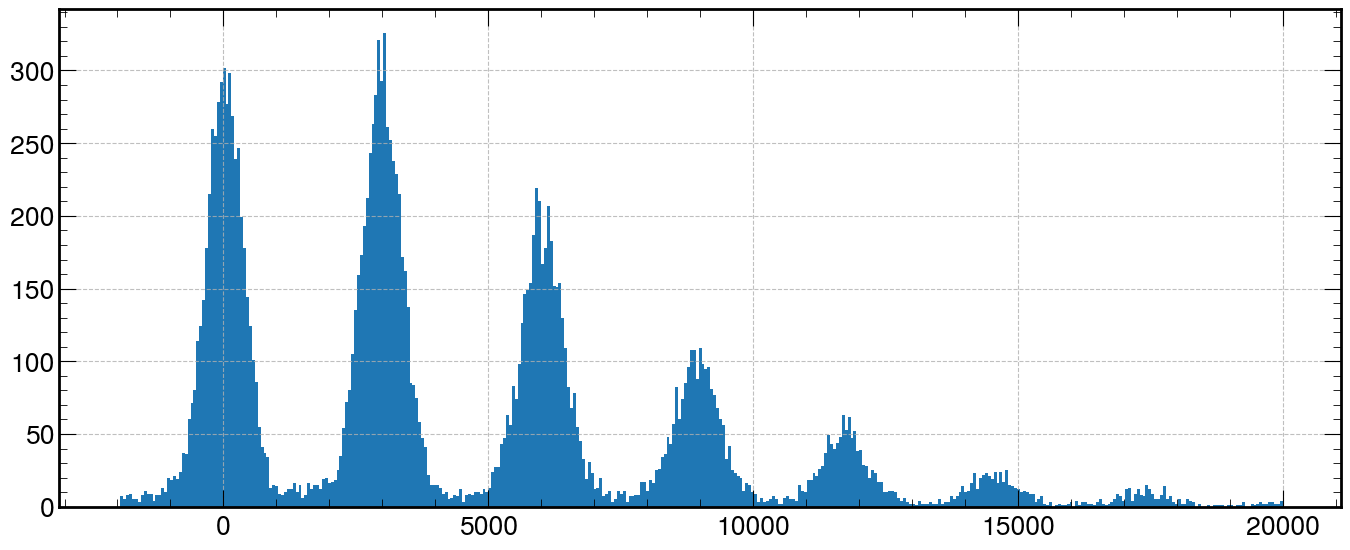

In [208]:
plt.hist(dataset[id].charge, bins=np.linspace(-2000,20000,400));

In [142]:
import numba as nb

@nb.njit
def matches(ts, qs, tref, tolerance=10):
    aux=0
    tvalid = []
    qvalid = []
    for t, q in zip(ts,qs):
        for i, tr in enumerate(tref[aux:]):
            if t > tr + tolerance:
                continue
            elif t >= tr-tolerance and t <= tr + tolerance:
                aux = i
                tvalid.append(t)
                qvalid.append(q)
                break
    return tvalid, qvalid

Run: 26244
Ch.1245, Self-trigger events: 18689
Ch.1245, LED events: 18689
18689
Total timelapse selftrigger: 300.19698688 s
Total timelapse led trigger: 300.19698688 s


Run: 26244
Ch.1245, Selftrigger events: 18689
Ch.1245, LED events: 18689
Total timelapse selftrigger: 300.20 s
Total timelapse led trigger: 300.20 s
Ch1245: 18689 over 18689 (100.0%)


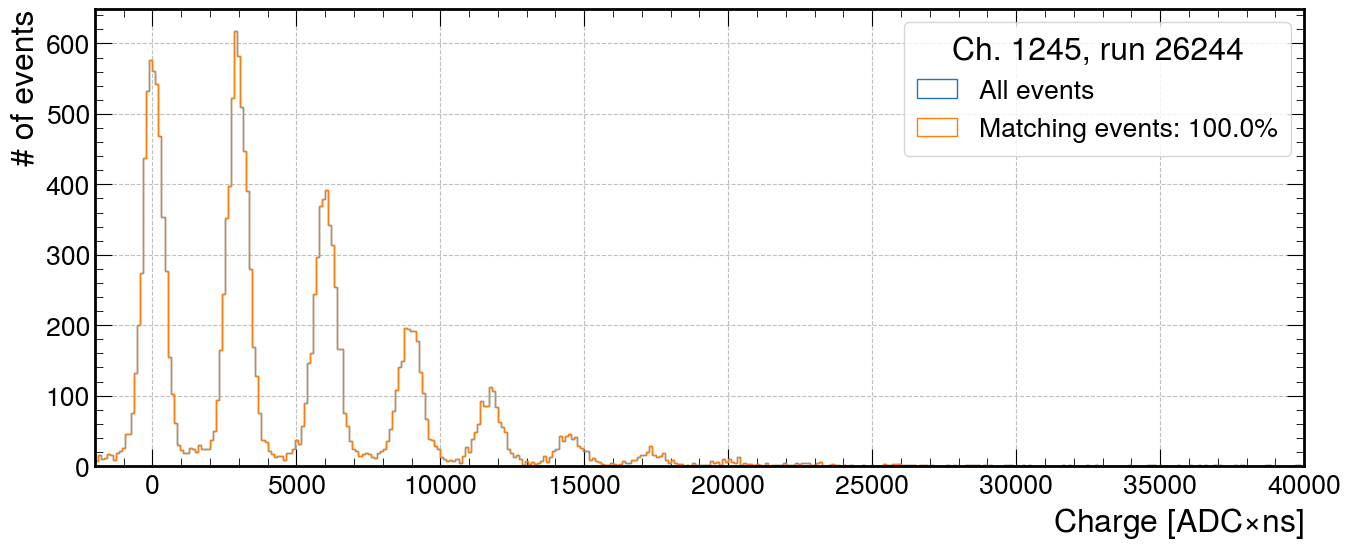

In [200]:
id=1245
idref = 1245

charges = dataset[id].charge
tstamp = dataset[id].time
tsref = dataset[idref].time
print(f"Run: {run}")
print(f"Ch.{id}, Self-trigger events: {len(tstamp)}")
print(f"Ch.{idref}, LED events: {len(tsref)}")
print(len(charges))

selfsort = np.argsort(tstamp)
refsort = np.argsort(tsref)

tstamp = tstamp[selfsort]
charges = charges[selfsort]

tsref = tsref[refsort]

print(f"Total timelapse selftrigger: {(tstamp[-1] - tstamp[0])*16e-9} s")
print(f"Total timelapse led trigger: {(tsref[-1] - tsref[0])*16e-9} s")
print()
print()

tstamp, cuni = np.unique(tstamp, return_index=True)
charges = charges[cuni]
tsref = np.unique(tsref)
print(f"Run: {run}")
print(f"Ch.{id}, Selftrigger events: {len(tstamp)}")
print(f"Ch.{idref}, LED events: {len(tsref)}")
print(f"Total timelapse selftrigger: {(tstamp[-1] - tstamp[0])*16e-9:.2f} s")
print(f"Total timelapse led trigger: {(tsref[-1] - tsref[0])*16e-9:.2f} s")


def drawSPE(charges, bins=np.linspace(-2000,40000,400), histtype='step', **kwargs):
    plt.hist(charges, bins=bins, histtype=histtype, **kwargs)
    plt.xlabel(r"Charge [ADC$\times$ns]")
    plt.ylabel(r"# of events")
    # plt.yscale('log')
    plt.xlim(bins[0], bins[-1])

    
drawSPE(charges, label='All events')

tvalid, qvalid = matches(tstamp, charges, tsref, 100)

drawSPE(qvalid, label=f'Matching events: {len(tvalid)*100./(len(tsref)):.1f}%')
print(f"Ch{id}: {len(tvalid)} over {len(tsref)} ({len(tvalid)*100/len(tsref):.1f}%)")
plt.legend(frameon=True, title=f'Ch. {id}, run {run}')


1341
1341
300196.98688
16.063623013698628
1.00352


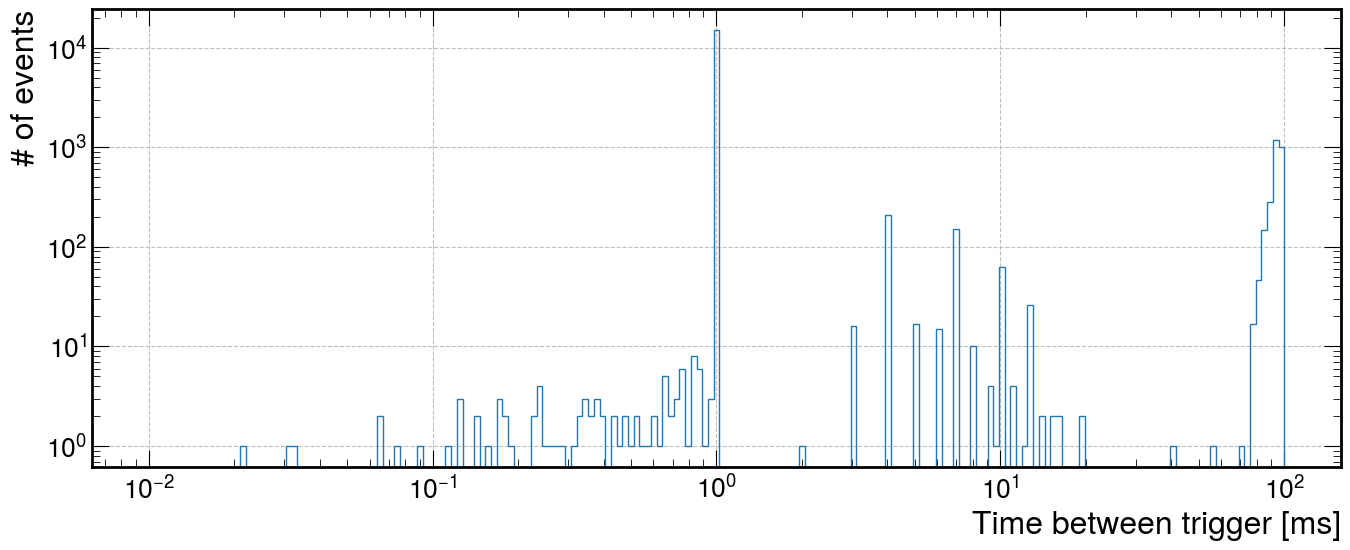

In [199]:
tstamp_diff = tstamp[1:]-tstamp[:-1]
minv = np.min(tstamp_diff)
print(minv)
tsref_diff = tsref[1:]-tsref[:-1]
minv = np.min(tsref_diff)
print(minv)
# np.where(tstemp_diff == minv)
# for v in charge[2444:2446]:
#     print(f"{v:.0f}")
# len(dataref[1302].time)
# plt.hist(tstamp_diff, bins=np.logspace(2,7,200),histtype='step');
masktime = tsref_diff*16e-6<0.8
plt.hist(tsref_diff*16e-6, bins=np.logspace(-2,2,200),histtype='step');
plt.xscale('log')
plt.yscale('log')
plt.ylabel("# of events")
plt.xlabel(r"Time between trigger [ms]")
print(sum(tsref_diff)*16e-6)
print(np.mean(tsref_diff)*16e-6)
print((st.mode(tsref_diff,keepdims=False)[0]*16e-6))

# timeref = dataset[idref].time[0:-1]
# chargeref = dataset[idref].charge[0:-1]
# timeref = timeref[masktime]
# print(len(chargeref))
# chargeref = chargeref[masktime]
# plt.figure()
# drawSPE(chargeref)


In [25]:
np.all(dataref[1302].time[:2440][:-1] <= dataref[1302].time[:2440][1:])

True

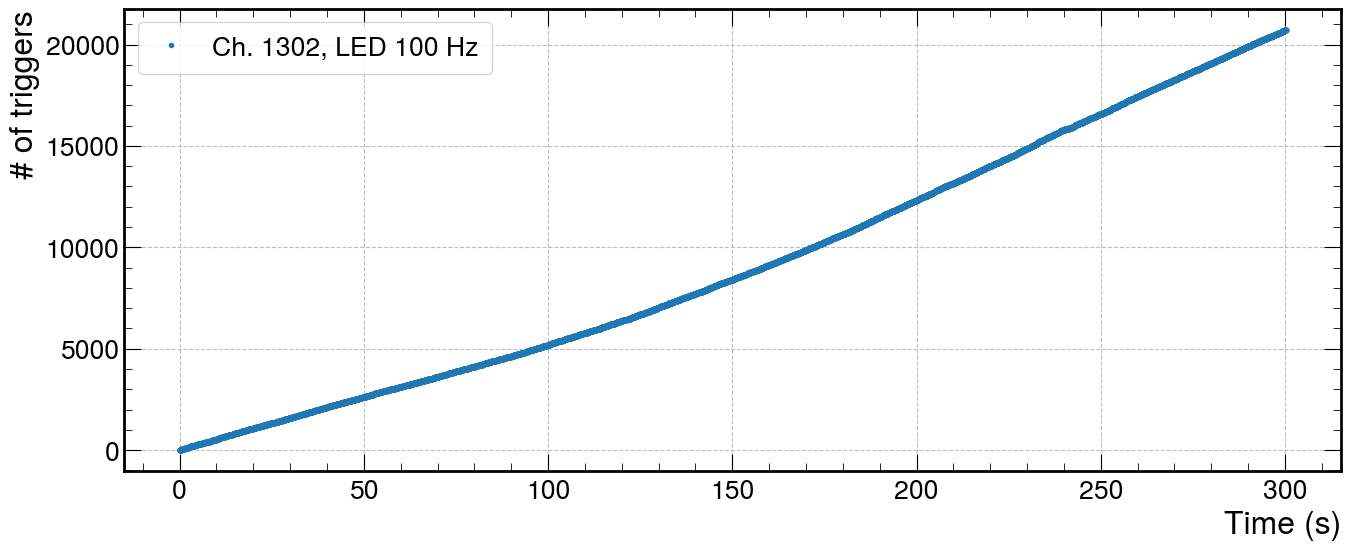

In [23]:
import matplotlib.dates as mdate
# print(f"{tstamp[0]:.0f} {tsref[0]:.0f} {tstamp[0] - tsref[0]:.0f}")
# print(f"{tstamp[-1]:.0f} {tsref[-1]:.0f} {tstamp[-1] - tsref[-1]:.0f}")

evtsself = [ i for i in range(len(tstamp))]
evtsref = [ i for i in range(len(tsref))]

timelapseref = (tsref[:] - tsref[0])*16e-9
timelapseself = (tstamp[:] - tstamp[0])*16e-9

# plt.plot(timelapseself, evtsself, '.', label=f'Ch. {id}, selftrigger')
plt.plot(timelapseref , evtsref, '.', label=f'Ch. 1302, LED 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('# of triggers')
plt.legend(frameon=True)